# Проект "Прогнозирование температуры плавления стали"

# Условие задачи


Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

# Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

# План проекта

1) Подготовка данных. Изменить тип данных, заполнить или удалить пропуски, где это необходимо.
2) Подготовка признаков. Определить нужные для модели данные и составить из них единую таблицу. Выделить как целевой признак последний замер температуры. Разделить на features и target.
3) Выбор модели. Обучить разные модели регрессии и выбрать из них наиболее подходящую.
4) Оценка. Оценить эффективность модели на тестовой выборке.

## Исследовательский анализ данных

### Импорт библиотек

In [54]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from pyod.models.knn import KNN
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')

In [55]:
data_arc = pd.read_csv('datasets/data_arc.csv')
data_bulk = pd.read_csv('datasets/data_bulk.csv')
data_bulk_time = pd.read_csv('datasets/data_bulk_time.csv')
data_gas = pd.read_csv('datasets/data_gas.csv')
data_temp = pd.read_csv('datasets/data_temp.csv')
data_wire = pd.read_csv('datasets/data_wire.csv')
data_wire_time = pd.read_csv('datasets/data_wire_time.csv')

### Ананлиз исходных данных

In [56]:
def data_analysis(data):

    display(data.head())
    print()
    columns = data.columns
    data_info = pd.DataFrame(columns=['Колонка', 'Пропуски', 'Кол-во значений', 'Пропуски (В процентах)', "Минимальное значение", "Максимальное значение", "Мeдианное значение"])

    for col in columns:
        is_null = data[col].isna().sum()
        isnt_null = data[col].count()
        percent = round(data[col].isna().sum() / (len(data[col] )/ 100), 2)
        try:
            min_value = data[col].min()
        except:
            min_value = 'NaN'
        try:
            max_value = data[col].max()
        except:
            max_value = 'NaN'
        try:
            median_value = data[col].median()
        except:
            median_value = 'NaN'
        list_data = [col, is_null, isnt_null, percent, min_value, max_value, median_value]
        data_info.loc[len(data_info.index)] = list_data

    data.info()

    print()
    keys = len(data['key'].unique())
    print('Количество уникальных партий: {}\n'.format(keys))

    return data_info

#### DATA ARC

*данные об электродах*

In [57]:
data_analysis(data_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB

Количество уникальных партий: 3214



,Колонка,Пропуски,Кол-во значений,Пропуски (В процентах),Минимальное значение,Максимальное значение,Мeдианное значение
0,key,0,14876,0.0,1,3241,1617.0
1,Начало нагрева дугой,0,14876,0.0,2019-05-03 11:02:14,2019-09-01 04:34:47,NaN
2,Конец нагрева дугой,0,14876,0.0,2019-05-03 11:06:02,2019-09-01 04:36:08,NaN
3,Активная мощность,0,14876,0.0,0.030002,3.731596,0.555517
4,Реактивная мощность,0,14876,0.0,-715.504924,2.676388,0.415962


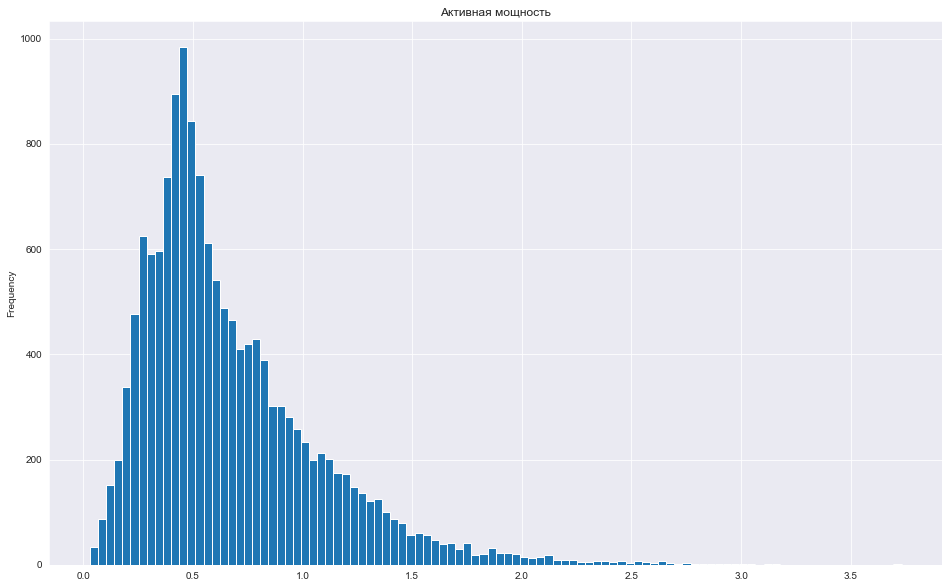

In [58]:
sns.set_style("dark")
data_arc['Активная мощность'].plot(kind='hist',figsize=(16,10),bins=100, grid=True)
plt.title('Активная мощность')
plt.show()

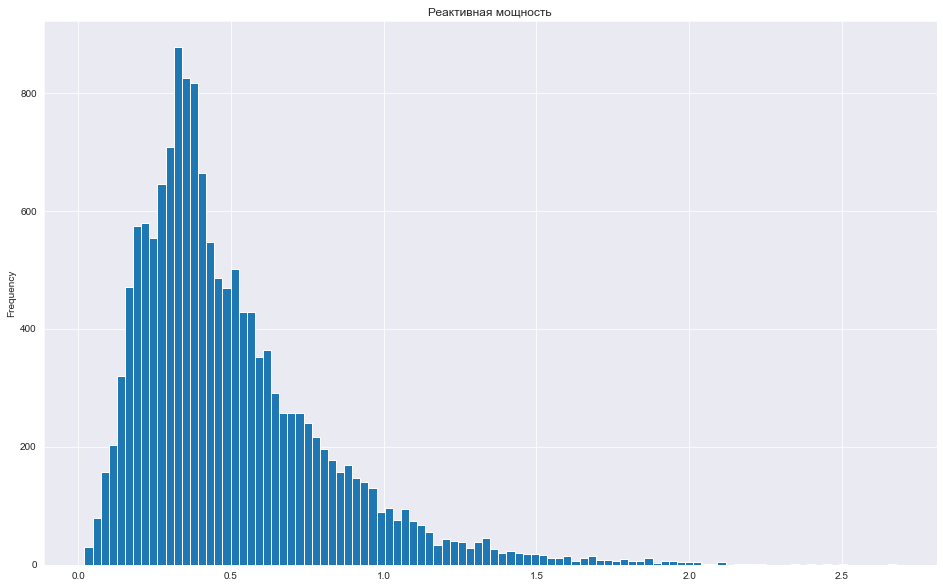

In [59]:
sns.set_style("dark")
data_arc[data_arc['Реактивная мощность'] > 0]['Реактивная мощность'].plot(kind='hist',figsize=(16,10),bins=100, grid=True)
plt.title('Реактивная мощность')
plt.show()

*Вывод*<br>
В данных нет пропусков и дубликатов. Столбцы с датой имеют тип обекта. В колонке "Реактивная мощность" имеются выбросы.

#### DATA BULK AND BULK TIME

данные о подаче сыпучих материалов (Объем и время)

In [60]:
data_analysis(data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB

Количество уникальных партий: 3129



,Колонка,Пропуски,Кол-во значений,Пропуски (В процентах),Минимальное значение,Максимальное значение,Мeдианное значение
0,key,0,3129,0.00,1.0,3241.0,1622.0
1,Bulk 1,2877,252,91.95,10.0,185.0,31.0
2,Bulk 2,3107,22,99.30,228.0,325.0,251.5
3,Bulk 3,1831,1298,58.52,6.0,454.0,97.5
4,Bulk 4,2115,1014,67.59,12.0,281.0,102.0
5,Bulk 5,3052,77,97.54,11.0,603.0,86.0
6,Bulk 6,2553,576,81.59,17.0,503.0,100.0
7,Bulk 7,3104,25,99.20,47.0,772.0,298.0
8,Bulk 8,3128,1,99.97,49.0,49.0,49.0
9,Bulk 9,3110,19,99.39,63.0,147.0,68.0


In [61]:
data_analysis(data_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB

Количество уникальных партий: 3129



,Колонка,Пропуски,Кол-во значений,Пропуски (В процентах),Минимальное значение,Максимальное значение,Мeдианное значение
0,key,0,3129,0.00,1,3241,1622.0
1,Bulk 1,2877,252,91.95,NaN,NaN,NaN
2,Bulk 2,3107,22,99.30,NaN,NaN,NaN
3,Bulk 3,1831,1298,58.52,NaN,NaN,NaN
4,Bulk 4,2115,1014,67.59,NaN,NaN,NaN
5,Bulk 5,3052,77,97.54,NaN,NaN,NaN
6,Bulk 6,2553,576,81.59,NaN,NaN,NaN
7,Bulk 7,3104,25,99.20,NaN,NaN,NaN
8,Bulk 8,3128,1,99.97,NaN,NaN,NaN
9,Bulk 9,3110,19,99.39,NaN,NaN,NaN


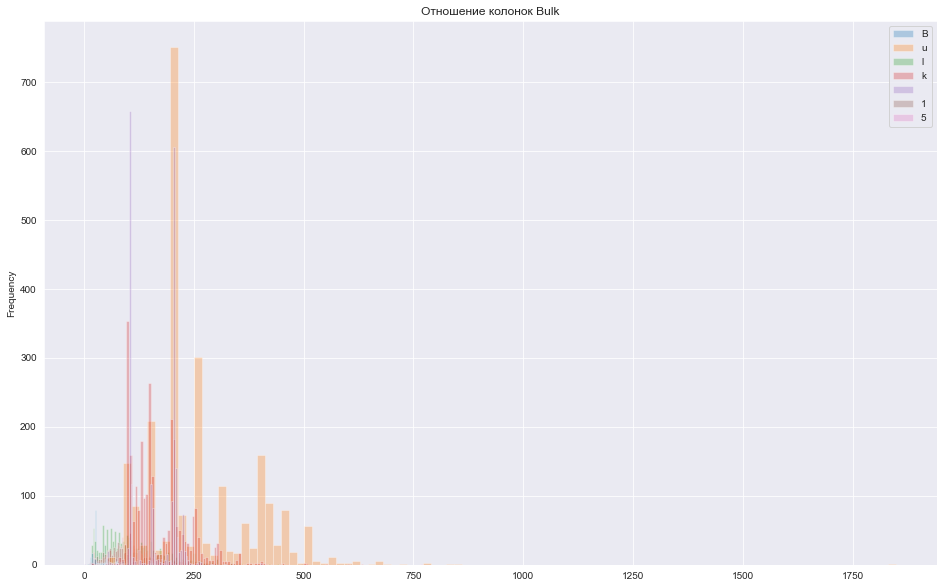

In [62]:
for column in data_bulk.columns:
    if column[0] == 'B':
        sns.set_style("dark")
        data_bulk[column].plot(kind='hist',figsize=(16,10),bins=100, grid=True, alpha=0.3)
        plt.title('Отношение колонок Bulk')
        plt.legend(column)

*Вывод*
В каждой колонке, кроме "Key" пропущенны значения. Но количество значений в каждом столбце совпадает в обеих таблицах.

#### DATA TEMP

результаты измерения температуры

In [63]:
data_analysis(data_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB

Количество уникальных партий: 3216



,Колонка,Пропуски,Кол-во значений,Пропуски (В процентах),Минимальное значение,Максимальное значение,Мeдианное значение
0,key,0,15907,0.00,1,3241,1618.0
1,Время замера,0,15907,0.00,2019-05-03 11:16:18,2019-09-01 04:38:08,NaN
2,Температура,2901,13006,18.24,1191.0,1705.0,1591.0


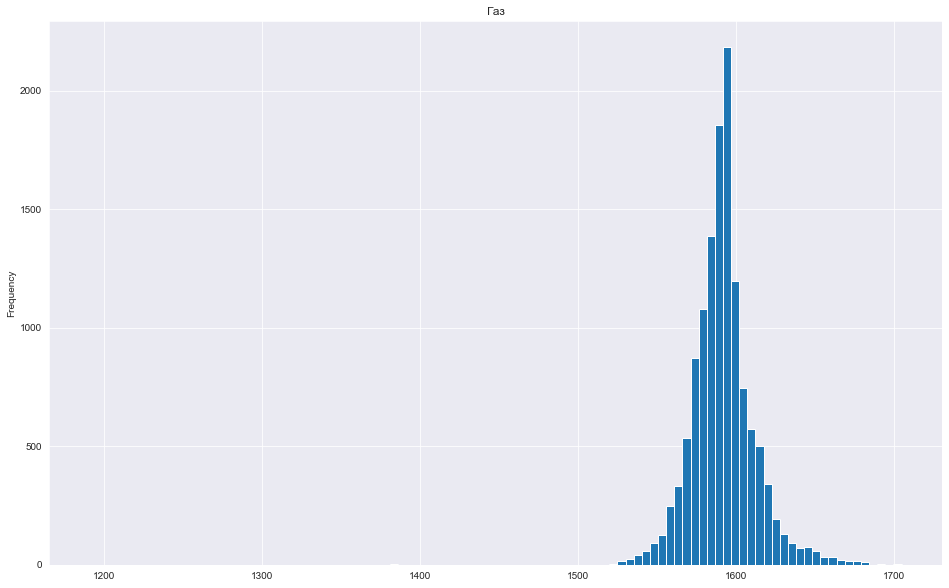

In [64]:
sns.set_style("dark")
data_temp['Температура'].plot(kind='hist',figsize=(16,10),bins=100, grid=True)
plt.title('Газ')
plt.show()

*Вывод*<br>
Пропущенны значения в столбце "Температура" (2901/15907). Для каждого ключа, с течением времени температура растет, следовательно, заполнить средним значением пропуски недопустимо, даже если применить группировку по ключу. Можно удалить строки с пропусками, т.к. замеров на один ключ разное количество, то это не создаст проблем.

#### DATA GAS

данные о продувке сплава газом

In [65]:
data_analysis(data_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

Количество уникальных партий: 3239



,Колонка,Пропуски,Кол-во значений,Пропуски (В процентах),Минимальное значение,Максимальное значение,Мeдианное значение
0,key,0,3239,0.0,1.000000,3241.00000,1622.000000
1,Газ 1,0,3239,0.0,0.008399,77.99504,9.836267


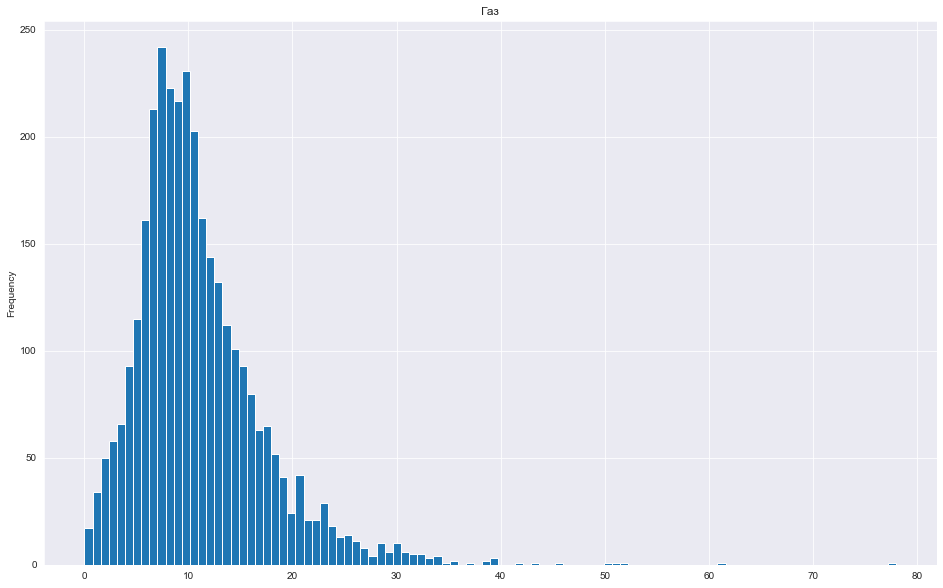

In [66]:
sns.set_style("dark")
data_gas['Газ 1'].plot(kind='hist',figsize=(16,10),bins=100, grid=True)
plt.title('Газ')
plt.show()

*Вывод* <br>
С данными все в порядке. Нет выбросов, пропусков и дубликатов

#### DATA WIRE AND WIRE TIME

данные о проволочных материалах (Объем и время)

In [67]:
data_analysis(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB

Количество уникальных партий: 3081



,Колонка,Пропуски,Кол-во значений,Пропуски (В процентах),Минимальное значение,Максимальное значение,Мeдианное значение
0,key,0,3081,0.00,1.000000,3241.000000,1619.000000
1,Wire 1,26,3055,0.84,1.918800,330.314424,100.158234
2,Wire 2,2002,1079,64.98,0.030160,282.780152,40.142956
3,Wire 3,3018,63,97.96,0.144144,385.008668,235.194977
4,Wire 4,3067,14,99.55,24.148801,113.231044,45.234282
5,Wire 5,3080,1,99.97,15.132000,15.132000,15.132000
6,Wire 6,3008,73,97.63,0.034320,180.454575,42.076324
7,Wire 7,3070,11,99.64,0.234208,32.847674,9.017009
8,Wire 8,3062,19,99.38,45.076721,102.762401,46.279999
9,Wire 9,3052,29,99.06,4.622800,90.053604,30.066399


In [68]:
data_analysis(data_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB

Количество уникальных партий: 3081



,Колонка,Пропуски,Кол-во значений,Пропуски (В процентах),Минимальное значение,Максимальное значение,Мeдианное значение
0,key,0,3081,0.00,1,3241,1619.0
1,Wire 1,26,3055,0.84,NaN,NaN,NaN
2,Wire 2,2002,1079,64.98,NaN,NaN,NaN
3,Wire 3,3018,63,97.96,NaN,NaN,NaN
4,Wire 4,3067,14,99.55,NaN,NaN,NaN
5,Wire 5,3080,1,99.97,NaN,NaN,NaN
6,Wire 6,3008,73,97.63,NaN,NaN,NaN
7,Wire 7,3070,11,99.64,NaN,NaN,NaN
8,Wire 8,3062,19,99.38,NaN,NaN,NaN
9,Wire 9,3052,29,99.06,NaN,NaN,NaN


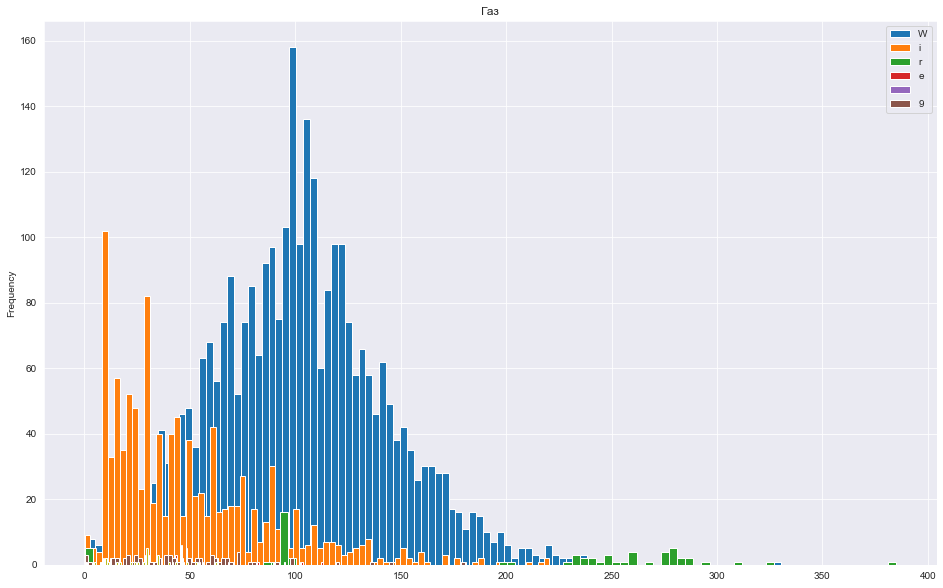

In [69]:
for column in data_wire.columns:
    if column[0] == 'W':
        sns.set_style("dark")
        data_wire[column].plot(kind='hist',figsize=(16,10),bins=100, grid=True)
        plt.title('Газ')
        plt.legend(column)

*Вывод*<br>
Данные совпадают по количеству в колонках, но колонки "wire 2" - "wire 9" имеют очень низкое количество значений. До 2% от всего количества возможных данных. 

### Вывод по анализу данных

Для успешного обучения модели нам понадобятся столбцы с затраченой мощностью таблицы data_arc. Таблица data_bulk. Измененная таблица data_temp, в которой посчитаем начальную и конечную температуру для каждой партии. Таблицы data_gas и data_wire.<br>
Количество уникальных партий в таблицах разное. А значит, некоторые либо утерены, либо не участвовали в этапе производства. Такие партии лучше удалить.

## Подготовка данных

Приведем названия столбцов к одному стилю для упращения дальнейшей работы

In [70]:
data_arc.columns = ['key', 'start_time','end_time', 'active_power', 'reactive_power']

Для финальной таблицы нам понадобится только колонка "active_power", т.к. реактивная мощность мало влияет на температуру.

In [71]:
data_arc_final = pd.pivot_table(data_arc,
                                values='active_power',
                                index='key',
                                aggfunc={'active_power': np.sum})

data_arc_final.head()

,active_power
key,
1,4.878147
2,3.052598
3,2.525882
4,3.209250
5,3.347173


Удалим из таблицы data_temp партии, которые не имеют последнего замера, либо их только один. Но для начала приведем названия колонок к единому стилю.

In [72]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [73]:
data_temp.columns = ['key', 'time', 'temperature']

In [74]:
bad_keys = []
for key in list(data_temp['key'].unique()):
    try:
        if ((data_temp[data_temp['key'] == key]['time'].max() < 
            data_arc[data_arc['key'] == key]['end_time'].max()) or
           (data_temp[data_temp['key'] == key]['time'].max() == 
            data_temp[data_temp['key'] == key]['time'].min())):
            bad_keys.append(key)
    except:
        bad_keys.append(key)
print('Количество не прошедших партий: ', len(bad_keys))

Количество не прошедших партий:  171


Удалим партии, имеющие пропуск в данных

In [75]:
keys_list = []
for i in range(0, len(data_temp['key'])):
    if np.isnan(data_temp['temperature'][i]) == True:
        key = data_temp['key'][i]
        keys_list.append(key)

for i in keys_list:
    data_temp = data_temp.loc[data_temp['key'] != i]
    
print(data_temp.isna().sum())

key            0
time           0
temperature    0
dtype: int64


Создадим таблицу с температурой первого и последнего замеров для каждой партии

In [76]:
data_temp_time = pd.pivot_table(data_temp,
                                values='time',
                                index='key',
                                aggfunc={'time': [np.min, np.max]})

data_temp_time

,amax,amin
key,,
1,2019-05-03 11:30:39,2019-05-03 11:16:18
2,2019-05-03 11:59:12,2019-05-03 11:37:27
3,2019-05-03 12:34:57,2019-05-03 12:13:17
4,2019-05-03 12:59:25,2019-05-03 12:52:57
5,2019-05-03 13:36:01,2019-05-03 13:23:19
...,...,...
2495,2019-08-06 00:54:42,2019-08-06 00:35:45
2496,2019-08-06 01:29:52,2019-08-06 01:02:54
2497,2019-08-06 01:53:50,2019-08-06 01:41:53


In [77]:
start_time_list = list(data_temp_time['amin'])
end_time_list = list(data_temp_time['amax'])
data_temp_start_temp = data_temp.query('time in @start_time_list ')
data_temp_start_temp = data_temp_start_temp.set_index('key')
data_temp_end_temp = data_temp.query('time in @end_time_list ')
data_temp_end_temp = data_temp_end_temp.set_index('key')
data_temp_final = data_temp_start_temp.copy()
data_temp_final.columns = ['time','start_temp']
data_temp_final['end_temp'] = data_temp_end_temp['temperature']
data_temp_final = data_temp_final.drop('time', axis=1)
data_temp_final.head()

,start_temp,end_temp
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


Для успешного обучения модели нам нужно объединить в одну таблицу таблицы: 'data_arc_final', 'data_temp_final', 'data_bulk', 'data_gas', 'data_wire'. Для последних четырех преобразуем индекс в значение столбца key и приведем названия колонок к одному стилю.

In [78]:
data_bulk = data_bulk.set_index('key')
data_bulk.columns = [f'bulk_{x}' for x in range(1,16)]
data_gas = data_gas.set_index('key')
data_gas.columns = ['gas']
data_wire = data_wire.set_index('key')
data_wire.columns = [f'wire_{x}' for x in range(1,10)]

Удалим пропущенные данные в колонках 'active_power', 'start_temp' и 'end_temp'. А так же удалим полностью столбец wire_5 из-за отсутсвия каких-либо данных

In [79]:
data_steel = pd.concat([data_arc_final, data_temp_final, data_bulk, data_gas, data_wire], axis=1, sort=False)
data_steel = data_steel.dropna(subset=['active_power', 'start_temp', 'end_temp'])
data_steel = data_steel.drop('wire_5',axis=1)
data_steel.info()
data_steel

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   active_power  2475 non-null   float64
 1   start_temp    2475 non-null   float64
 2   end_temp      2475 non-null   float64
 3   bulk_1        199 non-null    float64
 4   bulk_2        13 non-null     float64
 5   bulk_3        965 non-null    float64
 6   bulk_4        814 non-null    float64
 7   bulk_5        53 non-null     float64
 8   bulk_6        443 non-null    float64
 9   bulk_7        14 non-null     float64
 10  bulk_8        1 non-null      float64
 11  bulk_9        13 non-null     float64
 12  bulk_10       143 non-null    float64
 13  bulk_11       130 non-null    float64
 14  bulk_12       1882 non-null   float64
 15  bulk_13       14 non-null     float64
 16  bulk_14       2137 non-null   float64
 17  bulk_15       1713 non-null   float64
 18  gas           2473 non-null 

,active_power,start_temp,end_temp,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,...,bulk_15,gas,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,,,,,,,,,,,,,
1,4.878147,1571.0,1613.0,NaN,NaN,NaN,43.0,NaN,NaN,NaN,...,154.0,29.749986,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.052598,1581.0,1602.0,NaN,NaN,NaN,73.0,NaN,NaN,NaN,...,154.0,12.555561,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.525882,1596.0,1599.0,NaN,NaN,NaN,34.0,NaN,NaN,NaN,...,153.0,28.554793,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.209250,1601.0,1625.0,NaN,NaN,NaN,81.0,NaN,NaN,NaN,...,154.0,18.841219,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3.347173,1576.0,1602.0,NaN,NaN,NaN,78.0,NaN,NaN,NaN,...,152.0,5.413692,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,3.210690,1570.0,1591.0,NaN,NaN,21.0,NaN,NaN,NaN,NaN,...,223.0,7.125735,89.150879,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2496,4.203064,1554.0,1591.0,NaN,NaN,NaN,63.0,NaN,NaN,NaN,...,226.0,9.412616,114.179527,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2497,2.212379,1571.0,1589.0,NaN,NaN,NaN,85.0,NaN,NaN,NaN,...,226.0,6.271699,94.086723,9.04800,NaN,NaN,NaN,NaN,NaN,NaN


Изменим тип данных в 'start_temp', 'end_temp' и 'bulk' потому что там хранятся целые числа. Так же заполним пропуски нулями

In [80]:
data_steel = data_steel.fillna(0)
data_steel['start_temp'] = pd.to_numeric(data_steel['start_temp'], downcast='integer')
data_steel['end_temp'] = pd.to_numeric(data_steel['end_temp'], downcast='integer')
for i in range(1,16):
    data_steel[f'bulk_{i}'] = pd.to_numeric(data_steel[f'bulk_{i}'], downcast='integer')
data_steel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   active_power  2475 non-null   float64
 1   start_temp    2475 non-null   int16  
 2   end_temp      2475 non-null   int16  
 3   bulk_1        2475 non-null   int16  
 4   bulk_2        2475 non-null   int16  
 5   bulk_3        2475 non-null   int16  
 6   bulk_4        2475 non-null   int16  
 7   bulk_5        2475 non-null   int16  
 8   bulk_6        2475 non-null   int16  
 9   bulk_7        2475 non-null   int16  
 10  bulk_8        2475 non-null   int8   
 11  bulk_9        2475 non-null   int16  
 12  bulk_10       2475 non-null   int16  
 13  bulk_11       2475 non-null   int16  
 14  bulk_12       2475 non-null   int16  
 15  bulk_13       2475 non-null   int16  
 16  bulk_14       2475 non-null   int16  
 17  bulk_15       2475 non-null   int16  
 18  gas           2475 non-null 

### Оценка мультиколлинеарности

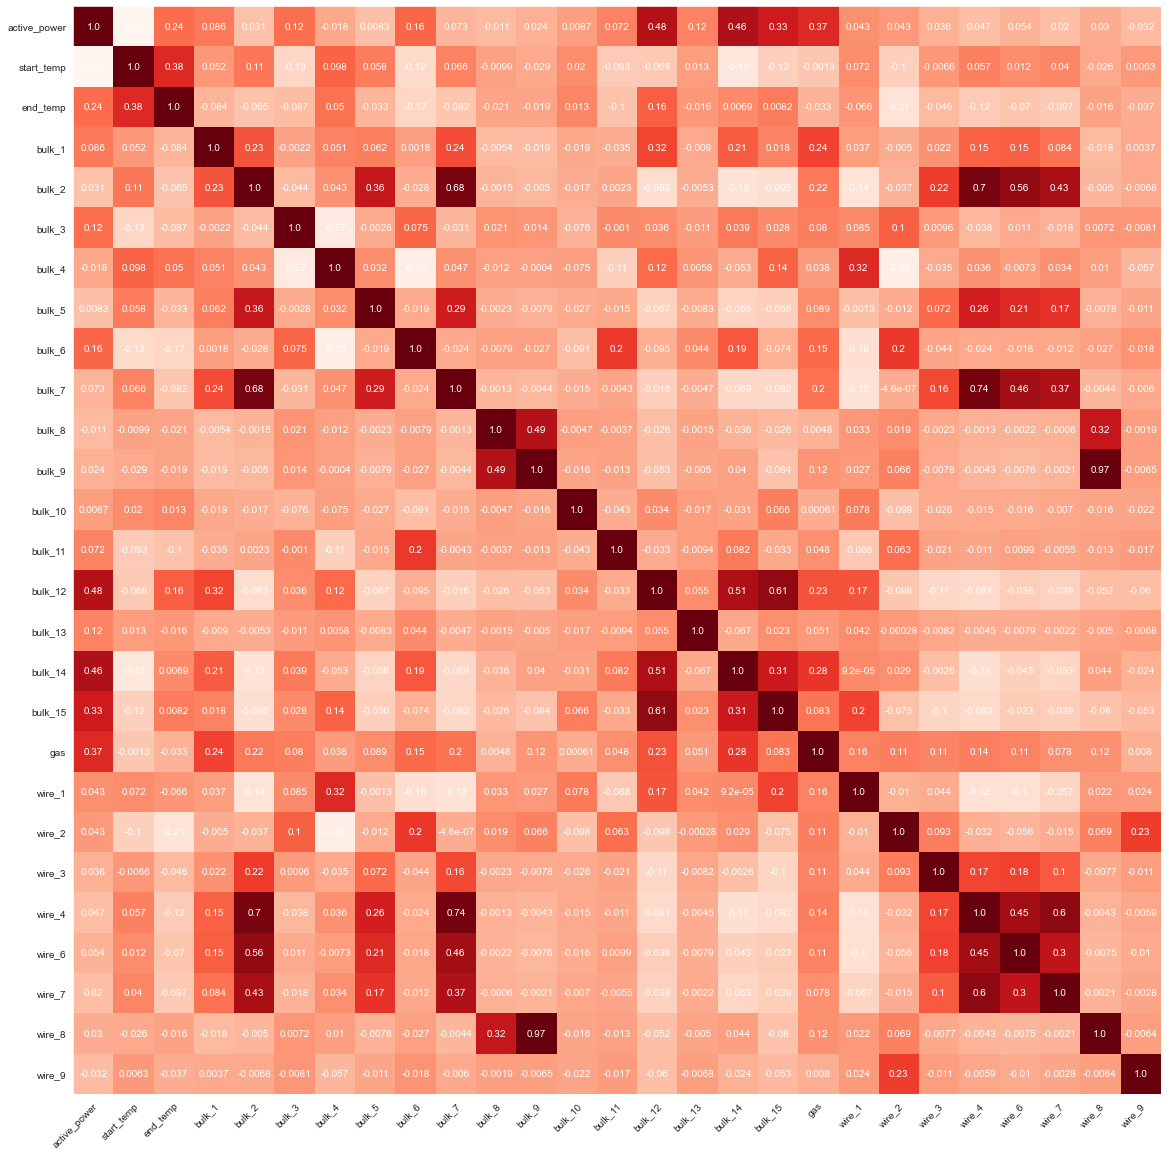

In [81]:
data_steel_knn = data_steel.copy()
corr_heatmap_data = data_steel_knn.corr()

fig, ax = plt.subplots(figsize=(20,20))
ax.set_xticks(np.arange(len(corr_heatmap_data.index)))
ax.set_yticks(np.arange(len(corr_heatmap_data.index)))

ax.set_xticklabels(corr_heatmap_data.index)
ax.set_yticklabels(corr_heatmap_data.index)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

data = corr_heatmap_data.values

for i in range(len(corr_heatmap_data.index)):
    for j in range(len(corr_heatmap_data.index)):
        text = ax.text(j, i, '{:.2}'.format(data[i, j]),
                       ha="center", va="center", color="w")
        
im = ax.imshow(corr_heatmap_data.corr(), cmap='Reds')

На heatmap видно, что есть сильная зависимость в колонках wire_8 и bulk_9. Удалим из таблицы одну из этих колонок.

In [82]:
data_steel_knn = data_steel_knn.drop('wire_8', axis=1)

### Поиск аномалий

Оценим влияние на столбец end_temp

In [83]:
data_steel_knn.corr()['end_temp'] 

active_power    0.238150
start_temp      0.376621
end_temp        1.000000
bulk_1         -0.083772
bulk_2         -0.064800
bulk_3         -0.086867
bulk_4          0.049758
bulk_5         -0.033281
bulk_6         -0.173874
bulk_7         -0.081665
bulk_8         -0.020502
bulk_9         -0.019433
bulk_10         0.012747
bulk_11        -0.100215
bulk_12         0.161748
bulk_13        -0.016352
bulk_14         0.006859
bulk_15         0.008165
gas            -0.033076
wire_1         -0.066263
wire_2         -0.205057
wire_3         -0.046035
wire_4         -0.115983
wire_6         -0.070397
wire_7         -0.096766
wire_9         -0.036733
Name: end_temp, dtype: float64

Возьмем столбцы, кореляция которых более 10%

In [84]:
data_steel_knn.corr()['end_temp'].abs() >= 0.1

active_power     True
start_temp       True
end_temp         True
bulk_1          False
bulk_2          False
bulk_3          False
bulk_4          False
bulk_5          False
bulk_6           True
bulk_7          False
bulk_8          False
bulk_9          False
bulk_10         False
bulk_11          True
bulk_12          True
bulk_13         False
bulk_14         False
bulk_15         False
gas             False
wire_1          False
wire_2           True
wire_3          False
wire_4           True
wire_6          False
wire_7          False
wire_9          False
Name: end_temp, dtype: bool

In [85]:
model = KNN()
data_steel_have_anomaly = data_steel_knn[['active_power',
                                          'start_temp',
                                          'end_temp',
                                          'bulk_6',
                                          'bulk_11',
                                          'bulk_12',
                                          'wire_2',
                                          'wire_4']]
model.fit(data_steel_have_anomaly)
data_steel_have_anomaly['is_outlier'] =  model.predict(data_steel_have_anomaly) == 1
outliers_knn = data_steel_have_anomaly['is_outlier'].sum()
print("Количество аномалий (KNN): ", outliers_knn)

outlier_indexes = list(data_steel_have_anomaly[data_steel_have_anomaly['is_outlier'] == 1].index)
good_indexes = list(set(data_steel_have_anomaly.index) - set(outlier_indexes))

data_steel_knn = data_steel_knn.drop(outlier_indexes)
data_steel_knn.shape

Количество аномалий (KNN):  214


(2261, 26)

### Вывод

Данные подготовлены. Target'ом будет столбец 'end_time', features - все остальные столбцы.

## Обучение модели

In [86]:
features = data_steel_knn.drop('end_temp', axis=1)
target = data_steel_knn['end_temp']

features_train, features_test, target_train, target_test = train_test_split(
                                                            features, 
                                                            target, 
                                                            test_size=0.25, 
                                                            random_state=12345)
cv_counts = 5

In [87]:
def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=features_test.columns).sort_values(ascending=False)

    plt.figure(figsize=(16, 10))
    ax = sns.barplot(x=feature_imp, y=feature_imp.index)
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')

Выберем следующие модели.

- LinearRegression
- RandomForestRegressor
- CatBoostRegressor
- LGBMRegressor
- XGBRegressor

### LinearRegression

In [88]:
%%time

regressor = LinearRegression()

cv_MAE_LR = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=cv_counts, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('MAE для LinearRegression на тренировочной выборке =', cv_MAE_LR)

#chart_feature_imp(regressor)

MAE для LinearRegression на тренировочной выборке = 7.4032287271878925
CPU times: total: 31.2 ms
Wall time: 30 ms


### RandomForestRegressor

In [89]:
%%time

regressor = RandomForestRegressor() 
hyperparams = [{'criterion':['mse'],
                'n_estimators':[x for x in range(100, 1001, 50)], 
                'random_state':[12345]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts)
clf.fit(features_train, target_train)

best_params_RFR = clf.best_params_
print(clf.best_params_)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_RFR = (max(means)*-1)
print('MAE для RandonForestRegressor на тренировочной выборке =', cv_MAE_RFR)

{'criterion': 'mse', 'n_estimators': 950, 'random_state': 12345}
6.000637 for {'criterion': 'mse', 'n_estimators': 100, 'random_state': 12345}
5.989282 for {'criterion': 'mse', 'n_estimators': 150, 'random_state': 12345}
5.981826 for {'criterion': 'mse', 'n_estimators': 200, 'random_state': 12345}
5.976182 for {'criterion': 'mse', 'n_estimators': 250, 'random_state': 12345}
5.963516 for {'criterion': 'mse', 'n_estimators': 300, 'random_state': 12345}
5.966545 for {'criterion': 'mse', 'n_estimators': 350, 'random_state': 12345}
5.971181 for {'criterion': 'mse', 'n_estimators': 400, 'random_state': 12345}
5.969630 for {'criterion': 'mse', 'n_estimators': 450, 'random_state': 12345}
5.967624 for {'criterion': 'mse', 'n_estimators': 500, 'random_state': 12345}
5.965599 for {'criterion': 'mse', 'n_estimators': 550, 'random_state': 12345}
5.966573 for {'criterion': 'mse', 'n_estimators': 600, 'random_state': 12345}
5.967679 for {'criterion': 'mse', 'n_estimators': 650, 'random_state': 12345}

### CatBoostRegressor

In [90]:
%%time

regressor = CatBoostRegressor(verbose=False, random_state=12345)

cv_MAE_CBR = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=cv_counts, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('MAE для CatBoostRegressor на тренировочной выборке =', cv_MAE_CBR)

MAE для CatBoostRegressor на тренировочной выборке = 5.7858401261486545
CPU times: total: 1min 9s
Wall time: 12.9 s


In [91]:
best_params_CBR = CatBoostRegressor(verbose=False, 
                                    random_state=12345).fit(features_train, 
                                        target_train).get_all_params()
best_params_CBR

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 12345,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.04450299963355064,
 'score_function': 'Cosine',
 'task_t

### LGBMRegressor

In [92]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[x for x in range(10,31)], 
                'learning_rate':[x/100 for x in range(1, 11)],
                'random_state':[12345]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts)
clf.fit(features_train, target_train)

best_params_LGBMR = clf.best_params_
print(clf.best_params_)
print()

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_LGBMR = (max(means)*-1)
print('MAE для LGBMRegressor на тренировочной выборке =', cv_MAE_LGBMR)

{'learning_rate': 0.06, 'num_leaves': 10, 'random_state': 12345}

7.401966 for {'learning_rate': 0.01, 'num_leaves': 10, 'random_state': 12345}
7.367214 for {'learning_rate': 0.01, 'num_leaves': 11, 'random_state': 12345}
7.340109 for {'learning_rate': 0.01, 'num_leaves': 12, 'random_state': 12345}
7.309419 for {'learning_rate': 0.01, 'num_leaves': 13, 'random_state': 12345}
7.289577 for {'learning_rate': 0.01, 'num_leaves': 14, 'random_state': 12345}
7.258838 for {'learning_rate': 0.01, 'num_leaves': 15, 'random_state': 12345}
7.236263 for {'learning_rate': 0.01, 'num_leaves': 16, 'random_state': 12345}
7.211423 for {'learning_rate': 0.01, 'num_leaves': 17, 'random_state': 12345}
7.194813 for {'learning_rate': 0.01, 'num_leaves': 18, 'random_state': 12345}
7.175177 for {'learning_rate': 0.01, 'num_leaves': 19, 'random_state': 12345}
7.162221 for {'learning_rate': 0.01, 'num_leaves': 20, 'random_state': 12345}
7.142322 for {'learning_rate': 0.01, 'num_leaves': 21, 'random_state': 12345

### XGBRegressor

In [93]:
%%time

regressor = XGBRegressor() 
hyperparams = [{'learning_rate':[x/100 for x in range(1, 51)],
                'random_state':[12345],
                 'silent':[True]}]


clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts)
clf.fit(features_train, target_train)

best_params_XGBR = clf.best_params_
print(clf.best_params_)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_XGBR = (max(means)*-1)
print('MAE для XGBRegressor на тренировочной выборке =', cv_MAE_XGBR)

[15:53:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:53:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:53:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false

## Тесты

### LinearRegression

In [94]:
%%time

model = LinearRegression()
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_MAE_LR = mean_absolute_error(target_predict, target_test)
print('MAE LinearRegression на тестовой выборке =', test_MAE_LR)

MAE LinearRegression на тестовой выборке = 7.891974440908566
CPU times: total: 0 ns
Wall time: 6 ms


### RandomForestRegression

MAE RandomForestRegressor на тестовой выборке = 5.971766784452295
CPU times: total: 8.09 s
Wall time: 8.12 s


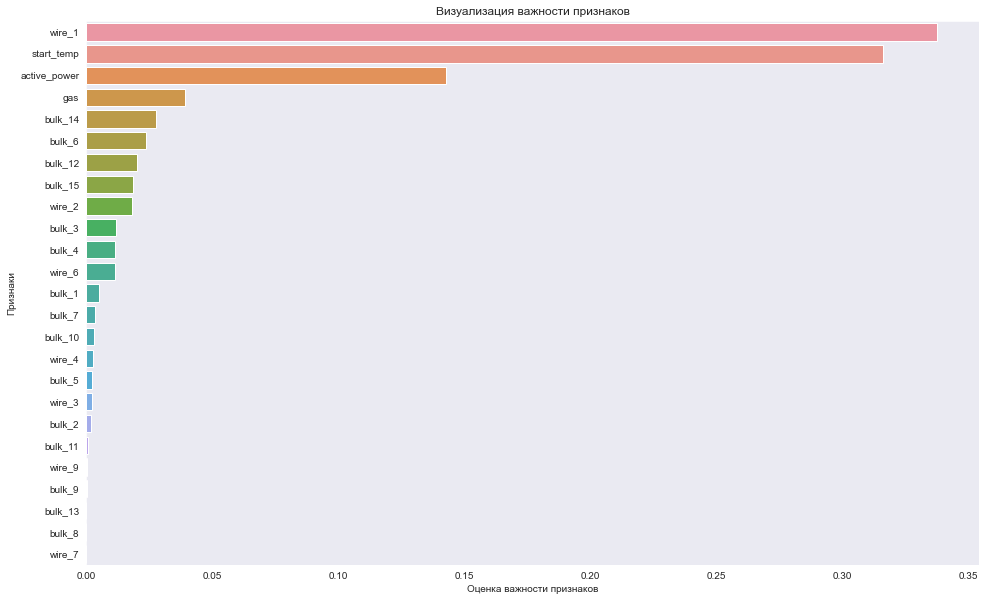

In [95]:
%%time

model = RandomForestRegressor()
model.set_params(**best_params_RFR)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_MAE_RFR = mean_absolute_error(target_predict, target_test)
print('MAE RandomForestRegressor на тестовой выборке =', test_MAE_RFR)

chart_feature_imp(model)

### CatBoostRegressor

MAE CatBoostRegressor на тестовой выборке = 5.963510975860937
CPU times: total: 13.5 s
Wall time: 2.35 s


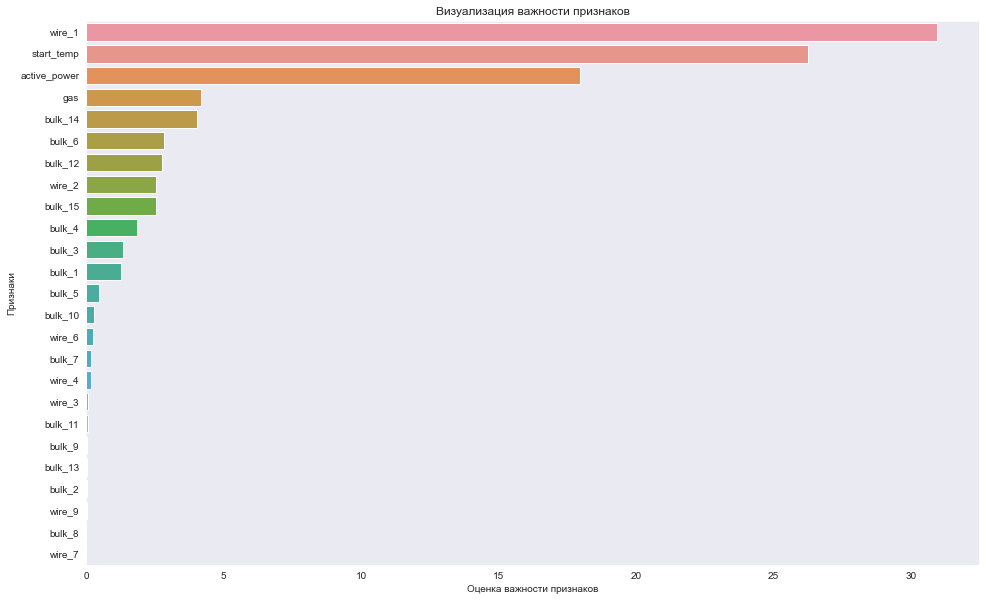

In [96]:
%%time

model = CatBoostRegressor(verbose=False)
model.set_params(**best_params_CBR)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_MAE_CBR = mean_absolute_error(target_predict, target_test)
print('MAE CatBoostRegressor на тестовой выборке =', test_MAE_CBR)

chart_feature_imp(model)

### LGBMRegressor

MAE LGBMRegressor на тестовой выборке = 5.902326529290728
CPU times: total: 1.22 s
Wall time: 115 ms


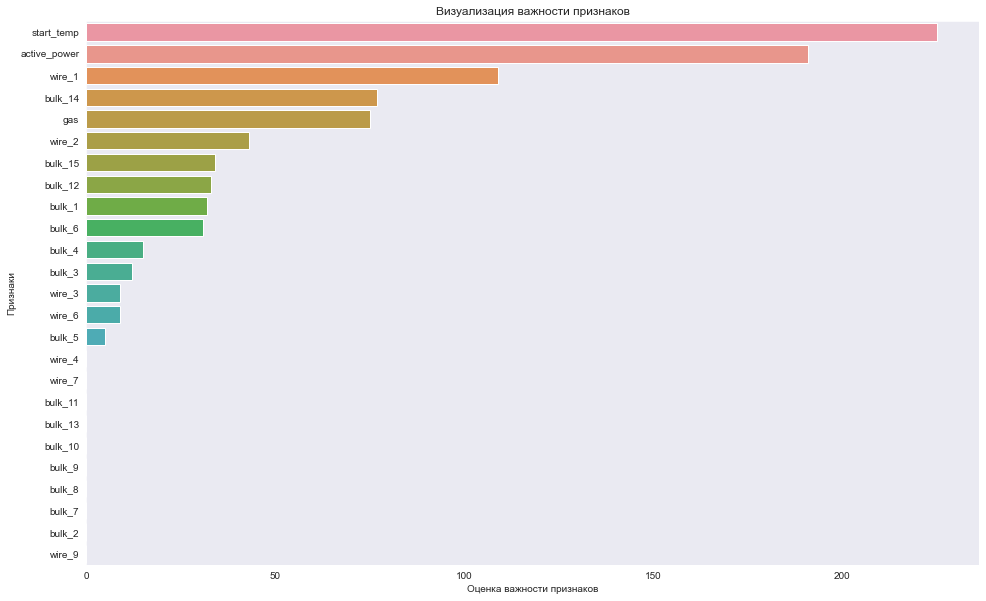

In [97]:
%%time

model = LGBMRegressor()
model.set_params(**best_params_LGBMR)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_MAE_LGBMR = mean_absolute_error(target_predict, target_test)
print('MAE LGBMRegressor на тестовой выборке =', test_MAE_LGBMR)

chart_feature_imp(model)

### XGBRegressor

[15:54:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


MAE XGBRegressor на тестовой выборке = 5.8451405
CPU times: total: 1.91 s
Wall time: 184 ms


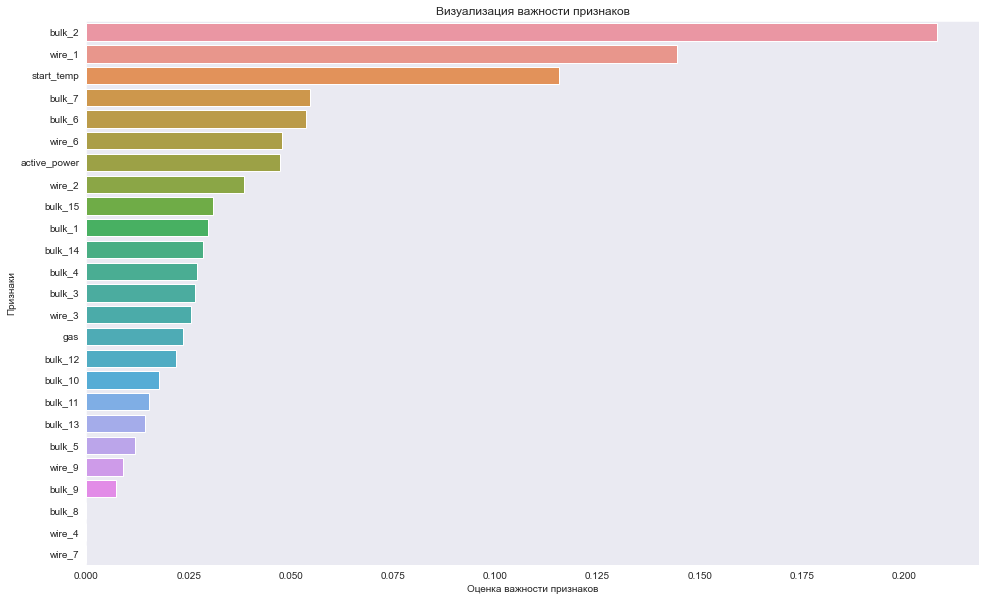

In [98]:
%%time

model = XGBRegressor()
model.set_params(**best_params_XGBR)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_MAE_XGBR = mean_absolute_error(target_predict, target_test)
print('MAE XGBRegressor на тестовой выборке =', test_MAE_XGBR)

chart_feature_imp(model)

## Выводы

In [99]:
index = ['LinearRegression',
         'RandomForestRegressor',
         'CatBoostRegressor',
         'LGBMRegressor',
         'XGBRegressor']
data = {'MAE на трейне':[cv_MAE_LR,
                     cv_MAE_RFR,
                     cv_MAE_CBR,
                     cv_MAE_LGBMR,
                     cv_MAE_XGBR],
        'MAE на тесте':[test_MAE_LR,
                        test_MAE_RFR,
                        test_MAE_CBR,
                        test_MAE_LGBMR,
                        test_MAE_XGBR]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Выполнение минимальной задачи'] = scores_data['MAE на тесте'] <= 8.7
scores_data['Выполнение идеальной задачи'] = scores_data['MAE на тесте'] <= 6
scores_data

,MAE на трейне,MAE на тесте,Выполнение минимальной задачи,Выполнение идеальной задачи
LinearRegression,7.403229,7.891974,True,False
RandomForestRegressor,5.958977,5.971767,True,True
CatBoostRegressor,5.785840,5.963511,True,True
LGBMRegressor,5.900374,5.902327,True,True
XGBRegressor,5.840317,5.845140,True,True


В ходе работы над проектом было выполнено.

- Подготовлены данные. Изменены типы данных и заполнены пропуски.
- Подготовлены признаки. Составлена единая таблица со всеми данными для модели. Выделен целевой признак как последний замер в серии замеров. Были убраны лишние таблицы wire_time и bulk_time, а так же лишние столбцы, кореляция которых была ниже 10% или они имели пропорциональные зависимости между собой.
- Выбраны модели. Использованы и обучены регрессионные модели.
- Оценена эффективность моделей на тестовой выборке.

Лучшей моделью стала XGBRegressor имея метрику МАЕ 5.85. Все остальные используемые модели так же прошли минимальный порог метрики < 8.7. И почти все модели, за исключением LinearRegression, прошли порог МАЕ < 6.0.

## Итоговый вывод

Все пункты плана были выполнены без особых затруднений. Данные были подготовлены и обработаны. Модели были обучены, а полученые метрики удовлетворяют запросу.<br>

В ходе работы я выделил следующие ключевые шаги:
- Правильное определение целевого признака и первичная обработка данных
- Правильная конкатенация таблиц для избежания потери данных
- Вторичная обработка данных. Удаление и\или заполнение пропусков, удаление лишних столбцов с учетом корреляции

При соблюдении всех этапов, почти все модели преодолели метрику идеальной задачи (менее 6.0), кроме линейной регрессии. Произошло так, скорее всего, из-за осутствия нелинейных связей у модели, но, тем не менее, модель преодолела минимально допустимую метрику, а именно менее чем 8.7. Лучшей же моделью стала XGBRegressor с метрикой 5.845140, но разница с остальными моделями минимальна, в пределах 0.1.